In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import keras 
import tensorflow as tf
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from keras.initializers import RandomNormal
from keras.layers import concatenate,MaxPooling2D
import cv2


In [3]:
file_path="../input/comic-faces-paired-synthetic/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/comics"
gt_path="../input/comic-faces-paired-synthetic/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face"
def read_image(path):
    img=cv2.imread(path)
    img=cv2.resize(img,(128,128))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    return img
"""def sketch_img(path):

    img=read_image(path)
    invert_img=cv2.bitwise_not(img)
    blur_img=cv2.GaussianBlur(invert_img, (111,111),0)
    invblur_img=cv2.bitwise_not(blur_img)
    sketch_img=cv2.divide(img,invblur_img,scale=256.0)
    return sketch_img"""

def image_preprocessing(img):
    img=img/255.0
    return img
ls=[]
for file in os.listdir(file_path):
    ls.append(file)
ls=ls[:1000]

(2000, 128, 128, 3)
(2000, 128, 128, 3)
128 128


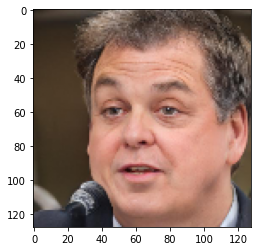

In [4]:

import cv2
def get_data(ls,file_path,gt_path):
    x_train=[]
    y_train=[]
    for file in ls:
        img_path=os.path.join(file_path,file)
        gt=os.path.join(gt_path,file)
        comic=image_preprocessing(read_image(img_path))
        #face=image_preprocessing(read_image(gt))
        face_img=read_image(gt)
        #sketch=sketch_img(gt)
        sketch=image_preprocessing(face_img)

        #performing data augmentation since we have few only 800 training images
        flip1=cv2.flip(comic,1)
        flip2=cv2.flip(sketch,1)
        x_train.append(sketch)
        x_train.append(flip2)
        y_train.append(comic)
        y_train.append(flip1)
    x_train=np.array(x_train)
    y_train=np.array(y_train)
    return x_train,y_train
x_train,y_train=get_data(ls,file_path,gt_path)



print(x_train.shape)
print(y_train.shape)

plt.imshow(x_train[0],cmap="gray")



h=x_train.shape[1]
w=x_train.shape[2]
#channel=x_train.shape[3]

print(h,w)

In [5]:
def Generator(x,y,z):
    inputs=Input(shape=(x,y,z))
    init = RandomNormal(stddev=0.02)
    c1=Conv2D(64,(4,4),strides=(2,2),activation="relu",kernel_initializer=init,padding="same")(inputs)
    c1=LeakyReLU(alpha=0.2)(c1)#(64,64,64)

    c2 = Conv2D(128, (4,4),strides=(2,2), kernel_initializer=init, padding='same')(c1)
    c2=BatchNormalization()(c2,training=True)#(128,32,32)
    c2=LeakyReLU(alpha=0.2)(c2)

    c3 = Conv2D(256 ,(4,4), strides=(2,2) ,kernel_initializer=init, padding='same')(c2)
    c3=BatchNormalization()(c3,training=True)#(256,16,16)
    c3=LeakyReLU(alpha=0.2)(c3)

    c4 = Conv2D(512, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(c3)
    c4=BatchNormalization()(c4,training=True)#(512,8,8)
    c4=LeakyReLU(alpha=0.2)(c4)

    c5 = Conv2D(512, (4,4),strides=(2,2),  kernel_initializer=init, padding='same')(c4)
    c5=BatchNormalization()(c5,training=True)#512,4,4
    c5=LeakyReLU(alpha=0.2)(c5)  

    c6 = Conv2D(512, (4,4), strides=(2,2),kernel_initializer=init, padding='same')(c5)
    c6=BatchNormalization()(c6,training=True)#512,2,2
    c6=LeakyReLU(alpha=0.2)(c6)  

    c7 = Conv2D(512, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(c6)
    #c7=BatchNormalization()(c7,training=True)#512,1,1
    #c7=LeakyReLU(alpha=0.2)(c7)  

    #b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(c7)
    b = Activation('relu')(c7)  

    d1 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(b)
    d1=BatchNormalization()(d1,training=True)#512*2*2
    d1=Dropout(0.5)(d1,training=True)
    d1=Concatenate()([d1, c6])   
    d1=Activation("relu")(d1)

    d2 =Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d1)
    d2=BatchNormalization()(d2,training=True)#512*4*4
    d2=Dropout(0.5)(d2,training=True)
    d2=Concatenate()([d2,c5])  
    d2=Activation("relu")(d2)

    d3 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d2)
    d3=BatchNormalization()(d3,training=True)#512*8*8
    d3=Dropout(0.5)(d3,training=True)
    d3=Concatenate()([d3, c4])   
    d3=Activation("relu")(d3)

    d4 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d3)
    d4=BatchNormalization()(d4,training=True)#512*16*16
    d4=Concatenate()([d4, c3])   
    d4=Activation("relu")(d4) 

    d5 = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d4)
    d5=BatchNormalization()(d5,training=True)#256*32*32
    d5=Concatenate()([d5, c2])   
    d5=Activation("relu")(d5) 

    d6 = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d5)
    d6=BatchNormalization()(d6,training=True)#128*64*64
    d6=Concatenate()([d6, c1])   
    d6=Activation("relu")(d6)     

    #d7 = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)
    #d7=BatchNormalization()(d7,training=True)
    #d7=Concatenate()([d7, c1])   
    #$d7=Activation("relu")(d7)    

    f = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6) 
    out_image = Activation('tanh')(f) #3,128,128

    model = Model(inputs, out_image)
    return model


In [6]:
def discriminator(h,w,c):
    init = RandomNormal(stddev=0.02) #kerenl initialiser
      
    
    in_src_image = Input(shape=(h,w,c))  
    
    in_target_image = Input(shape=(h,w,c))   
      
    
    merged = Concatenate()([in_src_image, in_target_image])
      
    
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)

    model = Model([in_src_image, in_target_image], patch_out)

      
    model.compile(loss='binary_crossentropy', optimizer="adam", loss_weights=[0.5])
    return model


In [7]:
def GAN(gen,dis,h,w,c):
    for layer in dis.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False         
    inp1=Input(shape=(h,w,1))
    inp2=Input(shape=(h,w,3))
    out=gen(inp2)
    main_out=dis([inp2,out])
    #print(main_out)
    #print(out)
    model=Model(inp2,[main_out,out])
    #we are using two loss function the binary cross entropy is mainly for the real-fake prediction 
    #the mse is the meas square loss which is for the loss calc between the ground truth and genenrated image
    #we want to put more weightge on the image generated to be more like the gt so we keep the weightage of it to be 100 times the real
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002,beta_1=0.5),loss=["binary_crossentropy","mae"],loss_weights=[1,100])
    return model


In [16]:

def train(gen,dis,comb,batch_size,epochs):
    discrim=[]
    generator_loss=[]
    half_batch=int(batch_size/2)
    batch_step=int(x_train.shape[0]/batch_size)
    for epoch in range(epochs):
        s=0
        for batch in range(batch_step):
            y_fake=gen.predict(x_train[s:s+half_batch])
            y_real=y_train[s:s+half_batch]
            x_real=x_train[s:s+half_batch]
            #training half batch with the real images and another half with fake images(model generated images)
            
            d_loss_real=dis.train_on_batch([y_real,x_real],np.ones((half_batch,8,8,1)))#training the discriminator in real images
            d_loss_fake=dis.train_on_batch([y_fake,x_real],np.zeros((half_batch,8,8,1)))#training the discriminator in fake images
            fak_pred=np.ones((batch_size,8,8,1))
            #now we will try out generator 
            #and to fool the discriminator we pass the generated image labels as the real image
            
            gan_loss,_,_=comb.train_on_batch(x_train[s:s+batch_size],[fak_pred,y_train[s:s+batch_size]])
            s=s+batch_size
        dis_loss=(d_loss_fake+d_loss_real)/2
        discrim.append(dis_loss)
        generator_loss.append(gan_loss)
        if epoch%10==0:
            path="./checkpoint/model-"+str(epoch)+".ckpt"
            gen.save_weights(path)
            
        print('epoch> %d,dis_real_loss[%.3f] dis_fake_loss[%.3f] generator_loss[%.3f]' % (epoch+1, d_loss_real, d_loss_fake,gan_loss)   )
        
    return discrim,generator_loss

In [17]:
x_train.shape[0]/64
np.ones((64,1))[1:10]
gen=Generator(128,128,3)
#print(gen.summary())
gen.compile(optimizer="adam",loss="binary_crossentropy",run_eagerly=True)
dis=discriminator(128,128,3)
model=GAN(gen,dis,128,128,1)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 128, 128, 3)  48662339    input_10[0][0]                   
__________________________________________________________________________________________________
model_4 (Functional)            (None, 8, 8, 1)      6968257     input_10[0][0]                   
                                                                 model_3[0][0]                    
Total params: 55,630,596
Trainable params: 48,656,451
Non-trainable params: 6,974,145
__________________________________________________________________________________________________


In [18]:
dis_loss,gen_loss=train(gen,dis,model,5,30)

2022-12-03 07:14:32.405713: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 1,dis_real_loss[0.001] dis_fake_loss[0.001] generator_loss[10.270]
epoch> 2,dis_real_loss[0.001] dis_fake_loss[0.002] generator_loss[9.877]


2022-12-03 07:16:44.691049: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 3,dis_real_loss[0.001] dis_fake_loss[0.017] generator_loss[9.996]
epoch> 4,dis_real_loss[0.001] dis_fake_loss[0.001] generator_loss[9.611]
epoch> 5,dis_real_loss[0.000] dis_fake_loss[0.005] generator_loss[9.341]
epoch> 6,dis_real_loss[0.000] dis_fake_loss[0.001] generator_loss[9.193]


2022-12-03 07:20:25.199847: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-12-03 07:20:27.853772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 7,dis_real_loss[0.042] dis_fake_loss[0.000] generator_loss[9.156]


2022-12-03 07:22:01.747438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 8,dis_real_loss[0.000] dis_fake_loss[0.002] generator_loss[8.740]


2022-12-03 07:22:36.720909: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 9,dis_real_loss[0.000] dis_fake_loss[0.001] generator_loss[8.574]


2022-12-03 07:23:31.429599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-12-03 07:23:31.822968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 10,dis_real_loss[0.000] dis_fake_loss[0.064] generator_loss[8.476]


2022-12-03 07:24:48.705991: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 11,dis_real_loss[0.000] dis_fake_loss[0.019] generator_loss[8.159]


2022-12-03 07:25:43.385412: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 12,dis_real_loss[0.000] dis_fake_loss[0.003] generator_loss[8.296]
epoch> 13,dis_real_loss[0.000] dis_fake_loss[0.250] generator_loss[7.932]
epoch> 14,dis_real_loss[0.001] dis_fake_loss[0.005] generator_loss[7.580]
epoch> 15,dis_real_loss[0.011] dis_fake_loss[0.011] generator_loss[7.663]
epoch> 16,dis_real_loss[0.001] dis_fake_loss[0.006] generator_loss[7.649]
epoch> 17,dis_real_loss[0.001] dis_fake_loss[0.008] generator_loss[7.028]
epoch> 18,dis_real_loss[0.000] dis_fake_loss[0.012] generator_loss[6.961]


2022-12-03 07:32:30.376623: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-12-03 07:32:57.492866: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 19,dis_real_loss[0.002] dis_fake_loss[0.010] generator_loss[6.786]
epoch> 20,dis_real_loss[0.031] dis_fake_loss[0.000] generator_loss[6.676]
epoch> 21,dis_real_loss[0.030] dis_fake_loss[0.005] generator_loss[6.484]


2022-12-03 07:35:48.532979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 22,dis_real_loss[0.000] dis_fake_loss[0.001] generator_loss[6.591]


2022-12-03 07:36:34.718238: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-12-03 07:36:36.553255: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 23,dis_real_loss[0.063] dis_fake_loss[0.007] generator_loss[6.198]
epoch> 24,dis_real_loss[0.004] dis_fake_loss[0.007] generator_loss[6.237]
epoch> 25,dis_real_loss[0.002] dis_fake_loss[0.018] generator_loss[6.123]
epoch> 26,dis_real_loss[0.004] dis_fake_loss[0.018] generator_loss[6.156]


2022-12-03 07:40:14.973199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch> 27,dis_real_loss[0.003] dis_fake_loss[0.003] generator_loss[5.974]
epoch> 28,dis_real_loss[0.010] dis_fake_loss[0.041] generator_loss[5.728]
epoch> 29,dis_real_loss[0.097] dis_fake_loss[0.016] generator_loss[5.592]
epoch> 30,dis_real_loss[0.028] dis_fake_loss[0.012] generator_loss[5.494]


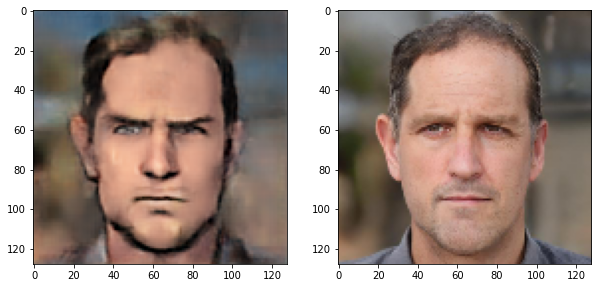

In [39]:
paath="../input/comic-faces-paired-synthetic/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face/1.jpg"
image=read_image(paath)
image=image_preprocessing(image)
image=np.expand_dims(image,axis=0)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
y=gen.predict(image)
plt.imshow(y[0])
plt.subplot(1,2,2)
plt.imshow(image[0])

In [34]:
#save model
gen.save(r"/kaggle/working/model")

In [89]:
def output_processing(img):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    im = cv2.filter2D(img, -1, kernel)
    im = cv2.blur(im,(2,2))

def generated_image(gen,data):
    if len(data.shape)==3:
        data=np.expand_dims(data,axis=0)
    predict=gen.predict(data)
    return predict


In [90]:
test_image=image_preprocessing(read_image("/kaggle/input/test3image/306862976_1801009746920274_6080128313312929705_n.jpg"))

(128, 128, 3)


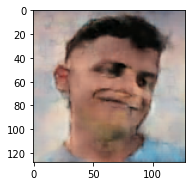

In [91]:
print(test_image.shape)
image=generated_image(gen,test_image)

plt.imshow(y[0])
plt.subplot(1,2,2)
plt.imshow(image[0])